In [2]:
import json
import os
from functools import partial

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from captum.attr import (
    IntegratedGradients,
    Lime,
    NoiseTunnel,
    Occlusion,
)
from captum.attr import visualization as viz

from lime import lime_image

from PIL import Image
from skimage.segmentation import mark_boundaries
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm

from util import Ham10000, initialize_model

In [3]:
idx_to_labels = {
    "0": ["akiec", "Actinic keratoses"],
    "1": ["bcc", "Basal cell carcinoma"],
    "2": ["bkl", "Benign keratosis-like lesions"],
    "3": ["df", "Dermatofibroma"],
    "4": ["nv", "Melanocytic nevi"],
    "5": ["vasc", "Vascular lesions"],
    "6": ["mel", "dermatofibroma"],
}

1. Load trained model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

result_dir = r"results\\20-12-01T16-36\\"

model_name = "efficientnet_b3a"
model, input_size = initialize_model(
    model_name, 7, use_pretrained=False, feature_extract=True
)

In [5]:
epoch = 7
weights = torch.load(
    result_dir + f"{model_name}_weights_{epoch}.pt", map_location=torch.device("cpu")
)
model.load_state_dict(weights)
print("Model loaded")
model.eval()

Model loaded


uential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (conv_dw): Conv2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=192, bias=False)
        (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(192, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(8, 192, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pwl): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(48, 288, ker

2. Load skin image

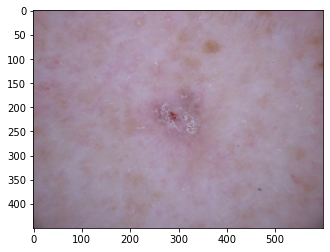

In [12]:
df = pd.read_csv(result_dir + "val.csv")
img = Image.open(df.iloc[6]["path"])
plt.imshow(img)

3. Transform image


In [13]:
with open(result_dir + "val_img_stats.json") as fp:
    stats = json.load(fp)

test_transform = transforms.Compose(
    [transforms.Resize((input_size, input_size)), transforms.ToTensor(),]
)

test_normalize = transforms.Normalize(stats["means"], stats["stdevs"])

transformed_img = test_transform(img)
input = test_normalize(transformed_img)
input = input.unsqueeze(0)

4. Predict skin lesion

In [14]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 3)
pred_label_idx.squeeze_()
prediction_score.squeeze()
for i in range(len(pred_label_idx)):
    predicted_label = idx_to_labels[str(pred_label_idx[i].item())][1]
    print("Predicted:", predicted_label, "(", prediction_score[0][i].item(), ")")

Predicted: Basal cell carcinoma ( 0.9818055033683777 )
Predicted: Benign keratosis-like lesions ( 0.01639699377119541 )
Predicted: Melanocytic nevi ( 0.0014063544804230332 )


In [15]:
prediction_score, pred_label_idx = torch.topk(output, 1)
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

5. Evaluates contribution of each input feature of the output of the model

### Integarted Gradient
assign an importance score to each input feature by approximating the integral of gradients of the model’s output with respect to the inputs along the path (straight line) from given baselines / references to inputs

In [16]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(
    input, target=pred_label_idx, n_steps=30, internal_batch_size=100
)

### Noise Tunnel
compute attributions using Integrated Gradients and smoothens them across multiple images generated by a noise tunnel

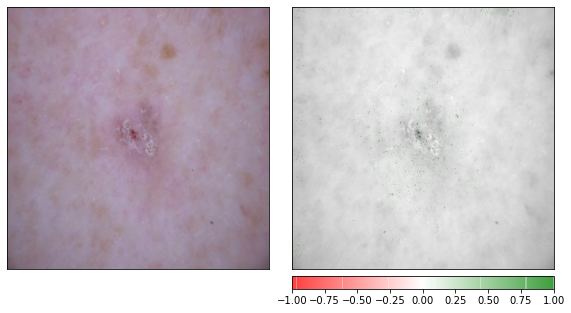

In [17]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(
    input, n_samples=1, nt_type="smoothgrad_sq", target=pred_label_idx
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "blended_heat_map"],
    ["all", "all"],
    alpha_overlay=0.5,
    show_colorbar=True,
)

### Occlusion
estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes

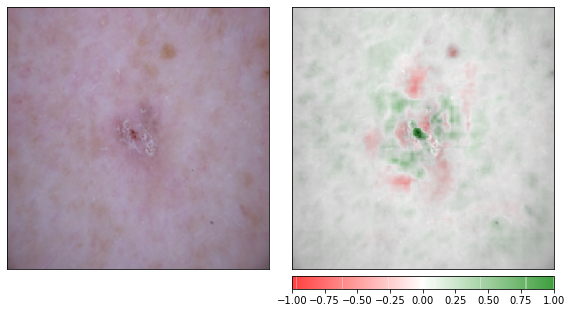

In [18]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    input,
    strides=(3, 4, 4),
    target=pred_label_idx,
    sliding_window_shapes=(3, 6, 6),
    baselines=0,
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "blended_heat_map"],
    ["all", "all"],
    show_colorbar=True,
    outlier_perc=2,
)

### LIME
generate an explanation for a prediction from the components of an interpretable model which resembles the black-box model at the vicinity of the point of interest

100%|██████████| 1000/1000 [08:20<00:00,  2.00it/s]


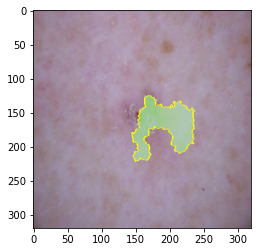

In [20]:
def get_pil_transform():
    transf = transforms.Compose([transforms.Resize((input_size, input_size))])
    return transf


def get_preprocess_transform():
    normalize = transforms.Normalize(stats["means"], stats["stdevs"])
    transf = transforms.Compose([transforms.ToTensor(), normalize])

    return transf


pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()


def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    np.array(pill_transf(img)),
    batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
)


temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False
)

img_boundry2 = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundry2)
plt.show()